## ДЗ №1. Метрики и простейшие алгоритмы рекомендаций

## Общая информация
**Дата выдачи: 4 февраля 2025**

**Дедлайн: 12 февраля 2025 23:59 MSK**

In [392]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from typing import List, Optional
from metric_tests import run_tests

pd.options.plotting.backend='plotly'
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## О задании

В этой работе мы посмотрим на то, как работают самые простые модели для рекомендаций. Как правило, они не требуют построения специальных моделей, но даже так оказываются полезны в качестве бейзлайна. Попробуем сделать предсказания с помощью EASE. Это тоже довольно простой подход, но не стоит забывать, что сложные модели могут оказаться не лучшим выбором в условиях большого количества данных. Посчитаем метрики, построим графики и подумаем, насколько хорошо эти модели вообще решают поставленную задачу.

Мы будем работать с датасетом по рекомендации фильмов от Kion MTS, который был дан для соревнования. Сперва нужно его предобработать, эта часть повторяет то, что было на семинаре. 

Датасет необходимо скачать: https://ods.ai/competitions/competition-recsys-21/data

Оттуда нужны файлы `interactions.csv` и `items.csv`

Каждое задание весит **1 балл**, если выполнено полностью и без ошибок, **0 баллов** ставится при наличии хотя бы 1 ошибки. Максимальная оценка - **10 баллов**. Шаблоны функций и классов можно менять по своему усмотрению.

In [409]:
df = pd.read_csv('interactions.csv').iloc[:-1]
df.head()

user_id  item_id last_watch_dt  total_dur  watched_pct
0   176549     9506    2021-05-11       4250         72.0
1   699317     1659    2021-05-29       8317        100.0
2   656683     7107    2021-05-09         10          0.0
3   864613     7638    2021-07-05      14483        100.0
4   964868     9506    2021-04-30       6725        100.0

In [406]:
df['last_watch_dt'] = (pd.to_datetime(df['last_watch_dt']) - pd.to_datetime(df['last_watch_dt']).min())
df['last_watch_dt'] = df.last_watch_dt.apply(lambda x: int(str(x).split()[0]))
df.sample(5)

user_id  item_id  last_watch_dt  total_dur  watched_pct
3739457   576537    11985             79       4554         79.0
2900629   197179     9728            104         20          0.0
5001659   781277     4116             84       9309        100.0
1949270   449035     4880            107          3          0.0
668494    233311     6208             66          5          0.0

Сделаем разбиение по времени

<Axes: >

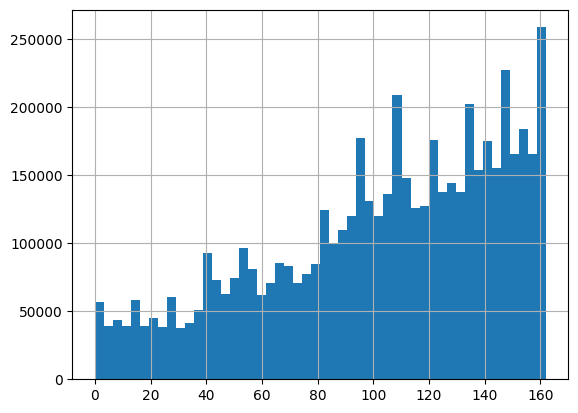

In [4]:
df.last_watch_dt.hist(bins=50)

In [5]:
train_df = df.loc[(df.last_watch_dt < 160-7)].copy()
test_df = df.loc[(df.last_watch_dt >= 160-7)].copy()

train_users = train_df.user_id.unique()
test_users = test_df.user_id.unique()

all_included = np.intersect1d(train_users, test_users)

print('число людей и там и там: ', all_included.shape[0])
print('число людей всего:', train_users.shape[0])

число людей и там и там:  134670
число людей всего: 880449


In [6]:
len(set(test_users) - set(train_users)) / len(test_users)

0.37768022181146027

И переведём всё к соединённому датасету:

In [7]:
n_users = 10000

all_included = np.random.choice(all_included, size=n_users, replace=False)

train_df = train_df.loc[train_df.user_id.isin(all_included)].copy()
test_df = test_df.loc[test_df.user_id.isin(all_included)].copy()

assert train_df.last_watch_dt.max() < test_df.last_watch_dt.min()
assert train_df.user_id.nunique() == n_users
assert test_df.user_id.nunique() == n_users

In [8]:
train_df.head()

user_id  item_id  last_watch_dt  total_dur  watched_pct
0     176549     9506             59       4250         72.0
32    141674     3813             60        129          2.0
56    580093    15411            151      10479        100.0
162   231912     3363            122        444          7.0
186   450102     3130             85        682          9.0

In [9]:
train_grouped = train_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                 x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
train_grouped.rename({0:'train_interactions'}, axis=1, inplace=True)

test_grouped = test_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                         x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
test_grouped.rename({0:'test_interactions'}, axis=1, inplace=True)

train_grouped.head()

/var/folders/5t/b05_gxx17hnftz_n3c82pt4h0000gn/T/ipykernel_9876/1105526701.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_grouped = train_df.groupby('user_id').apply(
/var/folders/5t/b05_gxx17hnftz_n3c82pt4h0000gn/T/ipykernel_9876/1105526701.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_grouped = test_df.groupby('user_id').apply(


user_id                                 train_interactions
0        3  [(2657, 82), (3734, 131), (9728, 132), (10440,...
1       55  [(9896, 15), (6192, 60), (3076, 99), (15297, 1...
2      106  [(9335, 28), (312, 35), (11494, 35), (12965, 5...
3      272                        [(12869, 40), (11310, 112)]
4      514                        [(5807, 113), (13865, 127)]

In [10]:
joined = train_grouped.merge(test_grouped)
joined.head()

user_id                                 train_interactions  \
0        3  [(2657, 82), (3734, 131), (9728, 132), (10440,...   
1       55  [(9896, 15), (6192, 60), (3076, 99), (15297, 1...   
2      106  [(9335, 28), (312, 35), (11494, 35), (12965, 5...   
3      272                        [(12869, 40), (11310, 112)]   
4      514                        [(5807, 113), (13865, 127)]   

                                   test_interactions  
0  [(142, 153), (10240, 156), (965, 156), (47, 15...  
1                                        [(14, 156)]  
2  [(12908, 159), (2836, 159), (12873, 159), (337...  
3  [(5398, 156), (9728, 156), (6561, 156), (15214...  
4                         [(7728, 156), (1453, 158)]

In [11]:
np.random.seed(777)

class Random:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        items = set()
        for _, row in df.iterrows():
            for item, _ in row[col]:
                items.add(item)

        self.items = list(items)
        self.trained = True

    def predict(self, df, topn=10):
        assert self.trained
        return [np.random.choice(self.items, replace=False, size=topn)]*len(df)


random = Random()
random.fit(joined)

joined['random_recs'] = random.predict(joined, topn=3)
joined.head()

user_id                                 train_interactions  \
0        3  [(2657, 82), (3734, 131), (9728, 132), (10440,...   
1       55  [(9896, 15), (6192, 60), (3076, 99), (15297, 1...   
2      106  [(9335, 28), (312, 35), (11494, 35), (12965, 5...   
3      272                        [(12869, 40), (11310, 112)]   
4      514                        [(5807, 113), (13865, 127)]   

                                   test_interactions          random_recs  
0  [(142, 153), (10240, 156), (965, 156), (47, 15...  [1944, 15994, 3105]  
1                                        [(14, 156)]  [1944, 15994, 3105]  
2  [(12908, 159), (2836, 159), (12873, 159), (337...  [1944, 15994, 3105]  
3  [(5398, 156), (9728, 156), (6561, 156), (15214...  [1944, 15994, 3105]  
4                         [(7728, 156), (1453, 158)]  [1944, 15994, 3105]

**Задание №1. Метрики и бейзлайны**

Добавьте реализацию метрик AP, RR, HR, их усреднённые версии по $U$ мы посчитаем ниже, если следовать коду с семинара, поэтому формулы немного отличаются. За имплементацию с циклами балл будет снижаться, векторизуйте! ( ͡° ͜ʖ ͡°)

$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$
p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)
$$
$$
RR@k = \dfrac{1}{\text{rank}_i@k}
$$
$$
HR@k = [\exists \ y_i = 1 \ \text{among k preds}]
$$


*   $n_u$ - число айтемов, с которыми взаимодействовал юзер $u$
*   $y_i$ - релевантно ли $i$-ое предсказание, $y_i \in \{0,1\}$
* $\text{rank}_i@k$ - позиция первого релеваннтого айтема среди первых $k$ предсказаний
* HR@k - среди первых $k$ предсказаний есть хотя бы одно релевантное

Считайте, что если `topn` не задано, то берётся всегда $n_u$. 

In [248]:
def ap_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int]=None
):
    if topn is None:
        topn = len(predictions)
    relevant_items = np.isin(predictions[:topn], gt_items)
    cum_relevant = np.cumsum(relevant_items)
    p_at_topn = cum_relevant / (np.arange(1, topn + 1))
    ap_at_topn = np.sum(p_at_topn * relevant_items)
    return ap_at_topn / min(topn, len(gt_items))


def rr_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int]=None
):
    if topn is None:
        topn = len(predictions)
    relevant_items = np.isin(predictions[:topn], gt_items)
    if np.any(relevant_items):
        first_relevant_idx = np.where(relevant_items)[0]
        return 1 / (first_relevant_idx[0] + 1)
    return 0


def hr_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int]=None
):
    if topn is None:
        topn = len(predictions)
    return int(len(set(gt_items).intersection(set(predictions[:topn]))) > 0)


Для вашего удобства в файле `metric_tests.py` есть тесты, но хардкодить их, разумеется, не стоит. 

In [249]:
run_tests(ap_metric, rr_metric, hr_metric)

В следующей ячейке код, который считает и усредняет метрики по юзерам. Он взят с семинара, при желании можно его тоже модифицировать, например, векторизовать. 

In [250]:
def evaluate_recommender(df, model_preds, gt_col='test_interactions'):

    metric_values = []

    for idx, row in df.iterrows():
        gt_items = [x[0] for x in row[gt_col]]
        predictions = row[model_preds]

        ap = ap_metric(gt_items, predictions)
        rr = rr_metric(gt_items, predictions)
        hr = hr_metric(gt_items, predictions)

        metric_values.append((ap, rr, hr))

    return {'map': np.mean([x[0] for x in metric_values]),
            'mrr': np.mean([x[1] for x in metric_values]),
            'hr': np.mean([x[2] for x in metric_values])}

Если вы всё сделали правильно, рандомные предсказания должны дать хоть какое-то качество, но не очень большое.

In [251]:
evaluate_recommender(joined, model_preds='random_recs')

{'map': np.float64(0.00017222222222222224),
 'mrr': np.float64(0.0004166666666666666),
 'hr': np.float64(0.0009)}

In [252]:
class TopPopular:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        counts = {}
        for _, row in df.iterrows():
            for item, _ in row[col]:
                if item in counts:
                    counts[item] += 1
                else:
                    counts[item] = 1

        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

        self.recommenations = [x[0] for x in counts]
        self.trained = True

    def predict(self, df, topn=10)  -> List[np.ndarray]:

        assert self.trained
        return [self.recommenations[:topn]]*len(df)


toppop = TopPopular()
toppop.fit(joined)

joined['toppopular_recs'] = toppop.predict(joined)
joined.head()

user_id                                 train_interactions  \
0        3  [(2657, 82), (3734, 131), (9728, 132), (10440,...   
1       55  [(9896, 15), (6192, 60), (3076, 99), (15297, 1...   
2      106  [(9335, 28), (312, 35), (11494, 35), (12965, 5...   
3      272                        [(12869, 40), (11310, 112)]   
4      514                        [(5807, 113), (13865, 127)]   

                                   test_interactions          random_recs  \
0  [(142, 153), (10240, 156), (965, 156), (47, 15...  [1944, 15994, 3105]   
1                                        [(14, 156)]  [1944, 15994, 3105]   
2  [(12908, 159), (2836, 159), (12873, 159), (337...  [1944, 15994, 3105]   
3  [(5398, 156), (9728, 156), (6561, 156), (15214...  [1944, 15994, 3105]   
4                         [(7728, 156), (1453, 158)]  [1944, 15994, 3105]   

                                     toppopular_recs  
0  [10440, 15297, 9728, 13865, 3734, 4151, 4880, ...  
1  [10440, 15297, 9728, 13865, 3734, 4151, 4880, ...  
2  [10440, 15297, 9728, 13865, 3734, 4151, 4880, ...  
3  [10440, 15297, 9728, 13865, 3734, 4151, 4880, ...  
4  [10440, 15297, 9728, 13865, 3734, 4151, 4880, ...

Самые популярные предсказания должны показать более высокое качество.

In [253]:
evaluate_recommender(joined, model_preds='toppopular_recs')

{'map': np.float64(0.06693375028344671),
 'mrr': np.float64(0.11868753968253969),
 'hr': np.float64(0.2732)}

**Задание №2. Рекомендации в окне**

Здесь необходимо переделать метод рекомендации по популярности так, что популярность считается только за какое-то более свежее временное окно. Под окном подразумевается какой-то временной промежуток, например, ближайший месяц. Соответственно, всё что за его пределами, не учитывается.

In [340]:
class TopPopularWeighted(TopPopular):

    def __init__(self, min_window=2):
        super().__init__()
        self.min_window = min_window

    def fit(self, df, col='train_interactions'):
        counts = {}
        
        # определяю последнюю доступную дату (от нее буду считать окно)
        max_dt = 0
        for _, row in joined.iterrows():
            for _, dt in row['train_interactions']:
                if dt > max_dt:
                    max_dt = dt

        for _, row in df.iterrows():
            for item, dt in row[col]:
                if dt >= (max_dt - self.min_window):
                    if item in counts:
                        counts[item] += 1
                    else:
                        counts[item] = 1
        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
        self.recommenations = [x[0] for x in counts]
        self.trained = True

    def predict(self, df, topn=10)  -> List[np.ndarray]:
        return super().predict(df, topn)
        # assert self.trained
        # return [self.recommenations[:topn]]*len(df)

In [342]:
toppop_weighted = TopPopularWeighted(min_window=2)
toppop_weighted.fit(joined)
joined['toppopular_weighted_recs'] = toppop_weighted.predict(joined)
joined.head()

user_id                                 train_interactions  \
0        3  [(2657, 82), (3734, 131), (9728, 132), (10440,...   
1       55  [(9896, 15), (6192, 60), (3076, 99), (15297, 1...   
2      106  [(9335, 28), (312, 35), (11494, 35), (12965, 5...   
3      272                        [(12869, 40), (11310, 112)]   
4      514                        [(5807, 113), (13865, 127)]   

                                   test_interactions          random_recs  \
0  [(142, 153), (10240, 156), (965, 156), (47, 15...  [1944, 15994, 3105]   
1                                        [(14, 156)]  [1944, 15994, 3105]   
2  [(12908, 159), (2836, 159), (12873, 159), (337...  [1944, 15994, 3105]   
3  [(5398, 156), (9728, 156), (6561, 156), (15214...  [1944, 15994, 3105]   
4                         [(7728, 156), (1453, 158)]  [1944, 15994, 3105]   

                                     toppopular_recs  \
0  [10440, 15297, 9728, 13865, 3734, 4151, 4880, ...   
1  [10440, 15297, 9728, 13865, 3734, 4151, 4880, ...   
2  [10440, 15297, 9728, 13865, 3734, 4151, 4880, ...   
3  [10440, 15297, 9728, 13865, 3734, 4151, 4880, ...   
4  [10440, 15297, 9728, 13865, 3734, 4151, 4880, ...   

                            toppopular_weighted_recs  
0  [10440, 9728, 15297, 4151, 7793, 3734, 12192, ...  
1  [10440, 9728, 15297, 4151, 7793, 3734, 12192, ...  
2  [10440, 9728, 15297, 4151, 7793, 3734, 12192, ...  
3  [10440, 9728, 15297, 4151, 7793, 3734, 12192, ...  
4  [10440, 9728, 15297, 4151, 7793, 3734, 12192, ...

In [343]:
# с окном по умолчанию (=2) показывает лучше результат, чем просто TopPopular
evaluate_recommender(joined, model_preds='toppopular_weighted_recs')

{'map': np.float64(0.07289395530990173),
 'mrr': np.float64(0.12657753968253968),
 'hr': np.float64(0.3437)}

Теперь постройте графики зависимости значений трёх метрик (AP@k, RR@k, HR@k) от размера окна. 

In [399]:
results = []
for window_size in tqdm(np.arange(1, 153)):
    toppop_weighted = TopPopularWeighted(min_window=window_size)
    toppop_weighted.fit(joined)
    joined['toppopular_weighted_recs'] = toppop_weighted.predict(joined)
    metrics = evaluate_recommender(joined, model_preds='toppopular_weighted_recs')
    results.append((window_size, metrics['map'], metrics['mrr'], metrics['hr']))

100%|██████████| 152/152 [01:26<00:00,  1.76it/s]


In [400]:
results = pd.DataFrame(results, columns=['window_size', 'MAP@k', 'MRR@k', 'HR@k'])
results.plot(x='window_size', y=['MAP@k', 'MRR@k', 'HR@k'])

Подумайте и ответьте, как размер окна влияет на качество рекомендаций. Какое значение наилучшее, есть ли у этого разумное объяснение?

**Ответ: чем меньше окно, тем больше метрики рекомендаций в данном случае. Наилучшее значение окна по данным метрикам - 1. Это обусловлено новизной популярных айтемов (мы рекомендуем айтемы среди тех, что были популярны вчера, а не месяц/год назад).**

**Задание №3. Метрики и k.**

Постройте зависимость значений MAP@K, MRR@K, HR@K для метода рекомендации по популярности. Возьмите какие-нибудь k, например, от 1 до 100, переберите значения и покажите на линейном графике. 

In [397]:
k_results = []
for k in tqdm(np.arange(1, 101)):
    joined['toppopular_recs'] = toppop.predict(joined, topn=k)
    metrics = evaluate_recommender(joined, model_preds='toppopular_recs')
    k_results.append((k, metrics['map'], metrics['mrr'], metrics['hr']))

100%|██████████| 100/100 [00:39<00:00,  2.50it/s]


In [402]:
k_results = pd.DataFrame(k_results, columns=['k', 'MAP@k', 'MRR@k', 'HR@k'])
k_results.plot(x='k', y=['MAP@k', 'MRR@k', 'HR@k'])

Хорошенько подумайте и ответьте на вопросы ниже.

3.1 Какие из метрик являются монотонными функциями по top-K? Объясните, почему они являются монотонными? \
**Ответ: начиная с k = 10 метрики MAP@k и MRR@k монотонны. MRR@k основана на позиции первого релевантного объекта, поэтому при "хороших" рекомендациях эта метрика несильно меняется (исключение: случаи, когда среди top-K айтемов не было ни одного релевантного для большинства юзеров = "плохие" рекомендации). MAP@k в свою очередь усредняет AP@k для всех пользователей в результате чего увеличения k на +1 при достаточном количестве айтемов приводит к увеличению AP@k среди одной части юзеров и уменьшению AP@k у другой половины -> в среднем MAP@k не изменяется.**

3.2 Объясните по каждой метрике, как можно интерпретировать ее график? То есть, что можно сказать про связь изменения метрики c возможными пользовательскими сценариями, например,скроллингом ленты новостей. \
**Ответ: про две метрики предположил в первом пункте. График метрики HR@K можно интерпретировать как неубывающий график (чем-то похож на логарифмическую функцию), посколько метрика показывает наличие хотя бы одного релевантного айтема среди первых k-айтемов. Если проводить аналог с возможным пользовательским сценарием - "скроллинг ленты новостей", то метрика HR@k будет не уменьшаться по мере скроллинга ленты (рано или поздно будет первый релевантная новость, интересная юзеру), MRR@k после достижения определенной релевантной новости будет константой, а MAP@k будет зависеть как от юзера, так и от рекомендуемых новостей: либо будут нравится все новости - высокий AP@k, либо частично - средний AP@k, либо вообще ни одна - низкий AP@k.**

3.3 Как вы думаете, почему графики выглядят именно так? Должны ли они возрастать/убывать, от чего это может зависеть? (Тут вам может помочь дополнительный анализ данных)\
**Ответ: скорее всего графики MAP@k и MRR@k в данном случае выглядят именно так, потому что рекомендации построены по топ-популярным товарам с расчетом на то, что все юзеры в среднем имеют одинаковую склонность к ним. В реальности же это не так и данная модель будет показывать менее монотонные результаты: либо лучше (когда все юзеры сильно склонны к популярным товарам и только), либо хуже (когда большая часть юзеров будет нейтрально/негативно на них настроены).**

**Задание №4. Интерпретация рейтингов**

Возьмите названия фильмов/сериалов из `items.csv`, выделите 5 различных сценариев изменения популярности у фильмов, аргументируйте (например, графиком или статистикой) и проинтерпретируейте их (почему популярность для этого фильма меняется так). Обратите внимание, что надо найти именно разные паттерны изменения вероятностей. 

In [842]:
items = pd.read_csv('items.csv')[['item_id','title']].copy()
items.head()

item_id                 title
0    10711        Поговори с ней
1     2508           Голые перцы
2    10716      Тактическая сила
3     7868                45 лет
4    16268  Все решает мгновение

Пример:

In [410]:
popular_items = df.item_id.value_counts()[:300].index.tolist()
sampled_id = np.random.choice(popular_items)

# это для примера, хотя выцеплять случаи по одному может быть не лучшей идеей
sampled_id = 3402

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

1917


Фильм 1917 какое-то время набирал популярность, потом видим резкое падение (кстати, с какой даты? **C 6 мая 2021**). Возможно, это связано с ограничением доступности этого фильма для части пользователей, периодом проката фильма / рекламной кампании или другой причиной. 

Добавьте 5 своих примеров ниже. Опишите, как вы их искали. 

In [444]:
# case 1 - "Резкий пик и затухание"
sampled_id = df['item_id'].value_counts(normalize=True).reset_index().iloc[0]['item_id']
interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(f'Название фильма - {name}, item_id = {sampled_id}')
interactions.last_watch_dt.hist()

Название фильма - Хрустальный, item_id = 10440.0


Первый паттерн - после месяца малого количества просмотров наблюдается резкий пик и затухание. Возможно был медиа-повод или рекламная кампания.

In [514]:
# case 2 - "Сезонность"
sampled_id = df['item_id'].value_counts(normalize=True).reset_index().iloc[7]['item_id']
interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(f'Название фильма - {name}, item_id = {sampled_id}')
interactions.last_watch_dt.hist()

Название фильма - Афера, item_id = 4880.0


Второй паттерн - двухнедельная сезонность, каждые две недели наблюдается локальный максимум. Возможно раз в 2 недели выходили новые рекламные ролики (материалы). Так же пики приходятся на выходные дни.

In [ ]:
# case 3 - "два пика"
sampled_id = df['item_id'].value_counts(normalize=True).reset_index().iloc[19]['item_id']
interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(f'Название фильма - {name}, item_id = {sampled_id}')
interactions.last_watch_dt.hist()

Название фильма - Приворот. Чёрное венчание, item_id = 14431.0


Третий паттерн - два пика - высокая популярность фильма в момент выхода и спустя 3 месяца. Причина второго пика может быть как рекламная кампания, так и инфоповоды.

In [ ]:
# case 4 - "Постепенный рост"
sampled_id = df['item_id'].value_counts(normalize=True).reset_index().iloc[33]['item_id']
interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(f'Название фильма - {name}, item_id = {sampled_id}')
interactions.last_watch_dt.hist()

Название фильма - Зверополис, item_id = 16166.0


Четвертый паттерн - восходящий тренд популярности с небольшой сезонностью - со временем фильм пользовался все большей и большей популярностью.

In [513]:
# case 5 - "Плавное затухание"
sampled_id = df['item_id'].value_counts(normalize=True).reset_index().iloc[35]['item_id']
interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(f'Название фильма - {name}, item_id = {sampled_id}')
interactions.last_watch_dt.hist()

Название фильма - Маленький воин, item_id = 3784.0


Пятый паттерн - пик популярности в момент выхода фильма и после плавное затухание популярности.

`Все паттерны находил по одинаковой схеме: посмотрел top-N самых популярных фильмов по просмотрам и после шел с 1 места до N, отбрасываю дублирующиеся паттерны.`

**Задание №5. User-item encoding**

Теперь, создайте матрицу интеракций user-item по примеру из семинара. Вам нужно в итоге получить разреженную матрицу (sparse matrix), в которой в качестве строк будут пользователи, в качестве колонок - айтемы. Не забудьте перекодировать пользователей и айтемы через энкодер. В отличие от семинара, оставьте в матрице только юзеров и айтемы, которые встречались в матрице > 4 раз.

Важно: когда вы отфильтруете юзеров на встречаемость > 4 раз, вы удалите какие-то айтемы, которые теперь станут встречаться меньше 5 раз. Поэтому у вас перестанет выполняться второе условие на минимальное число интеракций с айтемом. Тогда вам надо опять отфильтровать айтемы на встречаемость, но это снова может нарушить условие для юзеров. В таком случае, вам надо написать итеративный алгоритм до сходимости, пока требования не будут выполняться в обеих колонках. 

In [725]:
import warnings
warnings.filterwarnings('ignore')

def filter_column(df, min_freq):
    """
    Filter dataframe, excluding least active users and least popular items.
    Return a copy of the dataframe with at least min_freq entries
    in both users and items
    """

    col_freq = df.value_counts().reset_index().rename(columns={'count': 'freq'})  # считаю сколько раз встречается каждый юзер/айтем
    col_freq = col_freq[col_freq.freq >= min_freq]  # оставляю только те строки, где выполняется критерий min_freq
    df = col_freq.merge(df, how='right')  # присоединяю к изначальному вектору
    df['freq'] = df['freq'] / df['freq']  # теперь freq содержит только значени 1.0 и NaN
    df.iloc[:, 0] = df.iloc[:, 0] * df['freq']  # теперь неподходяющие юзеры/айтемы имеют id = NaN (который ниже мы будем дропать)
    df = df.drop(columns=['freq'])  # удаляем столбец freq, чтобы привести вектор к изначальному виду
    return df

def filter_dataframe(df, cols, min_freq=5):
    """
    Filter dataframe by given columns until each of them satisfies
    min_freq condition, guaranteed by filter_columns. Return a copy
    of the dataframe
    """
    df = df.reset_index(drop=True)
    is_passed = False  # выполняются ли условия min_freq по всем столбцам
    iteration = 0
    while not is_passed:
        iteration += 1
        is_passed = True
        print(f'iteration № {iteration} started!')
        for col in cols:
            df[col] = filter_column(df[col], min_freq=min_freq)
            if df[col].isna().sum() > 0:
                is_passed = False
        df = df.dropna().reset_index(drop=True)
        df[cols] = df[cols].astype(int)
    return df

filtered_train = filter_dataframe(df, ['user_id', 'item_id'])

iteration № 1 started!
iteration № 2 started!
iteration № 3 started!
iteration № 4 started!
iteration № 5 started!
iteration № 6 started!


In [726]:
filtered_train.head()

user_id  item_id last_watch_dt  total_dur  watched_pct
0   176549     9506    2021-05-11       4250         72.0
1   699317     1659    2021-05-29       8317        100.0
2   864613     7638    2021-07-05      14483        100.0
3  1032142     6686    2021-05-13      11286        100.0
4  1016458      354    2021-08-14       1672         25.0

In [727]:
print(f'Осталось {round(filtered_train.shape[0] / df.shape[0] * 100, 1)}% данных')

Осталось 78.1% данных


In [737]:
item2id = {k:v for v, k in enumerate(filtered_train.item_id.unique())}
user2id = {k:v for v, k in enumerate(filtered_train.user_id.unique())}

def df_encode(df):
    item2id = {k:v for v, k in enumerate(df.item_id.unique())}
    user2id = {k:v for v, k in enumerate(df.user_id.unique())}

    id2item = {k:v for v, k in item2id.items()}
    id2user = {k:v for v, k in user2id.items()}

    df['user_id'] = df.user_id.apply(lambda x: user2id[x])
    df['item_id'] = df.item_id.apply(lambda x: item2id[x])
    return df.reset_index(drop=True)

filtered_train = df_encode(filtered_train)
filtered_train.head(5)

user_id  item_id last_watch_dt  total_dur  watched_pct
0        0        0    2021-05-11       4250         72.0
1        1        1    2021-05-29       8317        100.0
2        2        2    2021-07-05      14483        100.0
3        3        3    2021-05-13      11286        100.0
4        4        4    2021-08-14       1672         25.0

In [738]:
len(user2id), len(item2id)

(302179, 10016)

In [739]:
from scipy import sparse as sps

matrix = sps.coo_matrix(
    (np.ones(filtered_train.shape[0]), (filtered_train['user_id'], filtered_train['item_id'])),
    shape=(len(user2id), len(item2id)),
)
matrix

<COOrdinate sparse matrix of dtype 'float64'
	with 4277820 stored elements and shape (302179, 10016)>

In [740]:
matrix.toarray()

array([[1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

**Задание №6. Интеракции и частота**

Постройте график зависимости количества айтемов и юзеров от значений (порогов) фильтров на встречаемость в матрице интеракций. То есть, нужно выполнить задание №5 для нескольких значений `min_freq` и построить график зависимости числа оставшихся айтемов и юзеров от этого параметра. 

In [721]:
from IPython.display import clear_output

thresholds = np.arange(101)

result = []
for threshold in tqdm(thresholds):
    filtered_train = filter_dataframe(df, ['user_id', 'item_id'], min_freq=threshold)
    users, items = filtered_train.user_id.nunique(), filtered_train.item_id.nunique()
    result.append((threshold, users, items))
    clear_output()


100%|██████████| 101/101 [02:44<00:00,  1.63s/it]


In [722]:
result_df = pd.DataFrame(result, columns=['min_freq', 'users', 'items'])
result_df.head()

min_freq   users  items
0         0  962151  15605
1         1  962151  15605
2         2  606936  13322
3         3  459099  11875
4         4  366891  10802

In [723]:
result_df.plot(x='min_freq', y=['users', 'items'])

**Задание №7. EASE**

Реализуйте EASE, постройте рекомендации для юзеров. Сравните все имплементированные ранее метрики качества с `TopPopular` для некоторого набора k. 

Реализацию можно взять из семинара. Можно реализовать по статье https://arxiv.org/pdf/1905.03375.pdf. Можно взять и адаптировать из RecBole https://github.com/RUCAIBox/RecBole.

In [750]:
%%time

# Обучаем конечную модель
# Мы взяли реализацию из RecBole

def fit_ease(X, reg_weight=100):
    
 # gram matrix
    G = X.T @ X

    # add reg to diagonal
    G += reg_weight * sps.identity(G.shape[0])

    # convert to dense because inverse will be dense
    G = G.todense()

    # invert. this takes most of the time
    P = np.linalg.inv(G)
    B = P / (-np.diag(P))
    # zero out diag
    np.fill_diagonal(B, 0.)
    
    return B

w = fit_ease(matrix)

CPU times: user 16 s, sys: 502 ms, total: 16.5 s
Wall time: 16.8 s


Далее, вам надо реализовать функцию получения предсказаний. У вас есть обученная матрица весов, которую можно использовать для получения предсказаний. Для этого нужно построить вектор интеракций пользователя и умножить его на матрицу весов.

In [748]:
id2item = {v: k for k, v in item2id.items()}
len(id2item), len(item2id)

(10016, 10016)

In [ ]:
def get_preds(x, item2id, id2item, topk=100):

    user_items = [t[0] for t in x]
    encoded = [item2id[t] for t in user_items if t in item2id]

    # Составляем вектор интеракций человека
    vector = np.zeros(len(item2id))
    vector[encoded] = 1

    vector = sps.csr_matrix(vector)

    preds = np.array(vector.dot(w))[0]#.toarray()
    preds[encoded==1] = -np.inf

    ranks = np.argsort(-preds)
    decoded = [id2item[t] for t in ranks][:topk]
    
    return decoded


joined['ease_preds'] = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item))
joined.head()

user_id                                 train_interactions  \
0        3  [(2657, 82), (3734, 131), (9728, 132), (10440,...   
1       55  [(9896, 15), (6192, 60), (3076, 99), (15297, 1...   
2      106  [(9335, 28), (312, 35), (11494, 35), (12965, 5...   
3      272                        [(12869, 40), (11310, 112)]   
4      514                        [(5807, 113), (13865, 127)]   

                                   test_interactions          random_recs  \
0  [(142, 153), (10240, 156), (965, 156), (47, 15...  [1944, 15994, 3105]   
1                                        [(14, 156)]  [1944, 15994, 3105]   
2  [(12908, 159), (2836, 159), (12873, 159), (337...  [1944, 15994, 3105]   
3  [(5398, 156), (9728, 156), (6561, 156), (15214...  [1944, 15994, 3105]   
4                         [(7728, 156), (1453, 158)]  [1944, 15994, 3105]   

                                     toppopular_recs  \
0  [10440, 9728, 15297, 4151, 7793, 3734, 12192, ...   
1  [10440, 9728, 15297, 4151, 7793, 3734, 12192, ...   
2  [10440, 9728, 15297, 4151, 7793, 3734, 12192, ...   
3  [10440, 9728, 15297, 4151, 7793, 3734, 12192, ...   
4  [10440, 9728, 15297, 4151, 7793, 3734, 12192, ...   

                            toppopular_weighted_recs  \
0  [10440, 15297, 9728, 13865, 3734, 4151, 4880, ...   
1  [10440, 15297, 9728, 13865, 3734, 4151, 4880, ...   
2  [10440, 15297, 9728, 13865, 3734, 4151, 4880, ...   
3  [10440, 15297, 9728, 13865, 3734, 4151, 4880, ...   
4  [10440, 15297, 9728, 13865, 3734, 4151, 4880, ...   

                                          ease_preds  
0  [10440, 15297, 9728, 3734, 13865, 4880, 2657, ...  
1  [15297, 4151, 10440, 3734, 142, 4880, 12192, 9...  
2  [16166, 10761, 3182, 4718, 16270, 13243, 7571,...  
3  [12275, 13018, 9091, 5250, 12173, 4696, 14741,...  
4  [10440, 9728, 5906, 3734, 12995, 2657, 8874, 1...

In [765]:
result = []
for k in tqdm(range(1, 102, 10)):
    joined['ease_preds'] = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item, topk=k))
    joined['toppopular_recs'] = toppop.predict(joined, topn=k)
    metrics_ease = evaluate_recommender(joined, model_preds='ease_preds')
    MAP_ease, MRR_ease, HR_ease = metrics_ease['map'], metrics_ease['mrr'], metrics_ease['hr']
    metrics_toppopular = evaluate_recommender(joined, model_preds='toppopular_recs')
    MAP_toppop, MRR_toppop, HR_toppop = metrics_toppopular['map'], metrics_toppopular['mrr'], metrics_toppopular['hr']
    result.append((k, MAP_ease, MRR_ease, HR_ease, MAP_toppop, MRR_toppop, HR_toppop))

100%|██████████| 11/11 [02:22<00:00, 12.92s/it]


In [769]:
ease_vs_toppop = pd.DataFrame(result, columns=['k', 'MAP_ease', 'MRR_ease', 'HR_ease', 'MAP_toppop', 'MRR_toppop', 'HR_toppop'])
ease_vs_toppop.plot(x='k', y=['MAP_ease', 'MRR_ease', 'HR_ease', 'MAP_toppop', 'MRR_toppop', 'HR_toppop'])

Сделайте выводы — какой алгоритм работает лучше?

**Ответ: по всем метрикам качества (MAP@k, MRR@k, HR@k) алгоритм EASE показывает лучший результат.**

**Задание №8. Тюнинг**

Переберите различные значения гиперпараметра коэффициента регуляризации у EASE и постройте графики, как в задании №6. Постарайтесь "затюнить" EASE как можно лучше. Возьмите разумное число гиперпараметров - хотя бы штук 20 по логарифмической сетке, либо используйте более хитрые алгоритмы оптимизации. 

In [783]:
thresholds = np.logspace(-1, 3, 20)

result = []
for reg_param in tqdm(thresholds):
    w = fit_ease(matrix, reg_weight=reg_param)
    joined['ease_preds'] = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item))
    metrics_ease = evaluate_recommender(joined, model_preds='ease_preds')
    MAP_ease, MRR_ease, HR_ease = metrics_ease['map'], metrics_ease['mrr'], metrics_ease['hr']
    result.append((reg_param, MAP_ease, MRR_ease, HR_ease))

reg_results = pd.DataFrame(result, columns=['reg_param', 'MAP@k', 'MRR@k', 'HR@k'])
reg_results

100%|██████████| 20/20 [09:18<00:00, 27.91s/it]


reg_param     MAP@k     MRR@k    HR@k
0      0.100000  0.094420  0.154942  0.7139
1      0.162378  0.094406  0.154908  0.7139
2      0.263665  0.094396  0.154890  0.7142
3      0.428133  0.094349  0.154891  0.7137
4      0.695193  0.094183  0.154712  0.7131
5      1.128838  0.094140  0.154726  0.7135
6      1.832981  0.094103  0.154836  0.7136
7      2.976351  0.093850  0.154679  0.7134
8      4.832930  0.093606  0.154577  0.7122
9      7.847600  0.093297  0.154298  0.7120
10    12.742750  0.092605  0.153523  0.7108
11    20.691381  0.092026  0.153132  0.7093
12    33.598183  0.091460  0.152679  0.7066
13    54.555948  0.091099  0.152611  0.7034
14    88.586679  0.090516  0.152024  0.6989
15   143.844989  0.090135  0.151965  0.6951
16   233.572147  0.089990  0.152064  0.6910
17   379.269019  0.089754  0.151860  0.6879
18   615.848211  0.089721  0.151888  0.6849
19  1000.000000  0.089660  0.151725  0.6814

In [784]:
reg_results.plot(x='reg_param', y=['MAP@k', 'MRR@k', 'HR@k'])

Ответьте на следующие вопросы:

8.1 Какое значение гиперпараметра является наилучшим? 


**Ответ: среди рассмотренных гиперпараметров наилучшее качество показывают минимальные - стремящиеся к нулю - при чем для всех метрик..**

8.2 Что еще интересного вы можете сказать по графикам? Может быть, что-то свзяанное с распределением параметров, влиянием на отдельные метрики, скоростью тюнинга?

**Ответ: с увеличением гиперпараметра регуляризации качество модели ухудшается. Время обучения одной модели составляет в среднем 30 секунд, что немного, сравнивая с моделями классического ML, но куда больше, чем скорость обучения модели TopPopular.**

**Задание №9. EASE и topk**

В лекции №2 говорилось, что качество у EASE растет с ослаблением фильтра на число айтемов. В этом задании постройте кривые метрик качества MAP/MRR/HR в зависимости от topk (например, от 1 до 100 с некоторым шагом), где кривая параметризована минимальным требуемым значением встречаемости user/item (из задания №6). Опишите свои выводы.

Важно: в этом задании линии могут быть мало различимыми, поэтому ваша задача для каждой метрики найти нужный масштаб на каких-то конкретных topk, чтобы линии стали визуально отличимы. 

In [799]:
result = []

for min_freq in tqdm(np.arange(1, 21)):
    filtered_train = filter_dataframe(df, ['user_id', 'item_id'], min_freq=min_freq)
    item2id = {k:v for v, k in enumerate(filtered_train.item_id.unique())}
    id2item = {v: k for k, v in item2id.items()}
    user2id = {k:v for v, k in enumerate(filtered_train.user_id.unique())}
    filtered_train = df_encode(filtered_train)
    matrix = sps.coo_matrix(
        (np.ones(filtered_train.shape[0]), (filtered_train['user_id'], filtered_train['item_id'])),
        shape=(len(user2id), len(item2id))
    )
    w = fit_ease(matrix)
    for k in tqdm(range(1, 102, 10)):
        joined['ease_preds'] = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item, topk=k))
        metrics_ease = evaluate_recommender(joined, model_preds='ease_preds')
        MAP_ease, MRR_ease, HR_ease = metrics_ease['map'], metrics_ease['mrr'], metrics_ease['hr']
        result.append((min_freq, k, MAP_ease, MRR_ease, HR_ease))
    clear_output()

100%|██████████| 20/20 [45:06<00:00, 135.34s/it]


In [800]:
minfreq_topk_ease = pd.DataFrame(result, columns=['min_freq', 'k', 'MAP_ease', 'MRR_ease', 'HR_ease'])
minfreq_topk_ease

min_freq    k  MAP_ease  MRR_ease  HR_ease
0           1    1  0.076400  0.076400   0.0764
1           1   11  0.076450  0.139333   0.3298
2           1   21  0.082217  0.146406   0.4392
3           1   31  0.085238  0.149120   0.5096
4           1   41  0.087048  0.150508   0.5597
..        ...  ...       ...       ...      ...
215        20   61  0.082647  0.143945   0.5928
216        20   71  0.083325  0.144319   0.6174
217        20   81  0.083869  0.144601   0.6389
218        20   91  0.084299  0.144767   0.6532
219        20  101  0.084665  0.144909   0.6668

[220 rows x 5 columns]

In [ ]:
minfreq_topk_ease.pivot_table(index='min_freq', columns='k', values='MAP_ease').plot(title='MAP@k')

In [823]:
minfreq_topk_ease.pivot_table(index='min_freq', columns='k', values='MRR_ease').plot(title='MRR@k')

In [822]:
minfreq_topk_ease.pivot_table(index='min_freq', columns='k', values='HR_ease').plot(title='HR@k')

Что вы можете сказать на основе полученных графиков? Соответствуют ли они вашим ожиданиям?

**Ответ: графики соответствуют ожиданиям: качество у алгоритма EASE действительно растет с ослаблением фильтра на количество айтемов. Также качество растет при увеличении параметра top-K.**

**Задание №10. Интерпретируемые рекомендации**

Используйте выученную матрицу весов для item2item рекомендаций. Приведите 10 примеров топ-5 рекомендаций от EASE к сэмплируемым айтемам. Используйте названия фильмов вместо id при выводе рекомендаций. 

In [825]:
filtered_train = filter_dataframe(df, ['user_id', 'item_id'], min_freq=1)
item2id = {k:v for v, k in enumerate(filtered_train.item_id.unique())}
id2item = {v: k for k, v in item2id.items()}
user2id = {k:v for v, k in enumerate(filtered_train.user_id.unique())}
filtered_train = df_encode(filtered_train)
matrix = sps.coo_matrix(
    (np.ones(filtered_train.shape[0]), (filtered_train['user_id'], filtered_train['item_id'])),
    shape=(len(user2id), len(item2id))
)
w = fit_ease(matrix)
joined['ease_preds'] = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item, topk=100))

iteration № 1 started!


In [ ]:
# матрица весов для item2item рекомендация
pd.DataFrame(w)

0         1         2         3         4         5      \
0      0.000000  0.006097  0.003710 -0.001273 -0.000610 -0.000412   
1      0.022826  0.000000  0.008619  0.001160  0.000209 -0.000524   
2      0.000882  0.000547  0.000000 -0.000546 -0.000403  0.000002   
3     -0.003661  0.000891 -0.006609  0.000000  0.001319 -0.000018   
4     -0.001269  0.000116 -0.003527  0.000954  0.000000  0.000528   
...         ...       ...       ...       ...       ...       ...   
15600  0.000294  0.000165  0.006264 -0.000063 -0.000042 -0.000074   
15601  0.000297  0.000195  0.000251 -0.000018  0.000084 -0.000093   
15602  0.000019 -0.000276 -0.000246  0.000197 -0.000268  0.000008   
15603 -0.000737  0.000191  0.000382 -0.000031 -0.000028 -0.000033   
15604 -0.000268 -0.000144 -0.000391 -0.000155 -0.000257 -0.000004   

              6         7         8         9      ...         15595  \
0     -4.587451e-05  0.000650  0.000120 -0.002977  ... -4.292722e-06   
1      6.474883e-04  0.005785 -0.001454  0.014589  ... -1.095873e-06   
2     -2.789502e-05  0.018926  0.000062 -0.001695  ... -4.856802e-06   
3     -3.600889e-05  0.013883 -0.000666 -0.001394  ...  4.924355e-06   
4      2.652666e-04 -0.002875 -0.000208  0.007631  ... -4.836021e-06   
...             ...       ...       ...       ...  ...           ...   
15600 -1.819431e-06 -0.002377 -0.000056 -0.000130  ...  2.550802e-06   
15601  1.685459e-05 -0.000218 -0.000011 -0.000491  ...  1.540907e-06   
15602 -3.237583e-05  0.000032 -0.000017 -0.000009  ...  1.205642e-07   
15603 -2.805085e-05 -0.000440 -0.000034 -0.000216  ... -2.217547e-06   
15604 -1.477038e-07 -0.000346 -0.000015 -0.000414  ... -7.979668e-06   

              15596         15597         15598         15599         15600  \
0      3.561828e-06  9.109350e-07 -4.496100e-06 -2.239447e-05  8.376319e-06   
1      4.660544e-06 -4.346541e-06 -6.057712e-06  1.879294e-04  1.759894e-05   
2     -1.038819e-06 -3.274897e-06 -7.532978e-07  6.069954e-07  4.237013e-05   
3     -6.283151e-06  5.483527e-06 -2.077550e-06  3.247493e-06 -5.146974e-06   
4     -1.800702e-06 -2.334813e-06  7.063988e-06 -1.694068e-06 -2.506006e-06   
...             ...           ...           ...           ...           ...   
15600  2.248201e-07  1.245128e-06  1.267213e-06 -1.309369e-06  0.000000e+00   
15601  8.975967e-07 -2.047919e-07  6.114679e-07 -5.201979e-05  2.263485e-06   
15602 -8.321411e-08 -3.968727e-05 -4.296337e-05  7.278499e-06 -9.396949e-07   
15603  1.106839e-06 -5.117279e-07  4.397569e-07  1.410785e-05  2.557799e-07   
15604  1.567248e-07 -1.943130e-08 -3.106034e-08  7.493393e-07  5.410355e-07   

              15601         15602         15603         15604  
0      8.459707e-06  5.464870e-07 -2.100155e-05 -7.632013e-06  
1      2.081065e-05 -2.929654e-05  2.034984e-05 -1.535880e-05  
2      1.695307e-06 -1.662575e-06  2.586179e-06 -2.649682e-06  
3     -1.514728e-06  1.607883e-05 -2.529900e-06 -1.274684e-05  
4      4.968217e-06 -1.581585e-05 -1.631992e-06 -1.528170e-05  
...             ...           ...           ...           ...  
15600  2.264644e-06 -9.375781e-07  2.561955e-07  5.420353e-07  
15601  0.000000e+00  2.623215e-06  6.860702e-07 -1.678743e-07  
15602  2.630484e-06  0.000000e+00  3.244070e-07 -4.491590e-09  
15603  6.853080e-07  3.231511e-07  0.000000e+00  8.741877e-07  
15604 -1.676504e-07 -4.473205e-09  8.739931e-07  0.000000e+00  

[15605 rows x 15605 columns]

In [923]:
# 10 сеймплируемых фильмов
sampled_films = np.random.randint(w.shape[0], size=10)
sampled_films


array([ 1446,  9236,  9705,  6369,  3567,   996,  8944,  4574, 12587,
       10017])

In [ ]:
for idx in sampled_films:
    # к ним найдем по 5 рекомендуемых фильмов 
    recommended_idx = pd.DataFrame(w).iloc[:, idx].sort_values(ascending=False).head(5).index.to_list()
    decoded_idx = id2item[idx]
    decoded_recommended_idx  = list(map(lambda id: id2item[id], recommended_idx))
    title1 = items[items.item_id == decoded_idx]['title'].to_list()[0]
    titles2 = ', '.join(['\"' + items[items.item_id == idx2]['title'].to_list()[0] + '\"' for idx2 in decoded_recommended_idx])
    print(f'Для фильма "{title1}" рекомендации: {titles2}')

Для фильма "Спрячь бабушку в холодильнике" рекомендации: "Шедевр", "Стажёр", "Отпетые мошенники", "Большая афера в маленьком городе", "Супруги Морган в бегах"
Для фильма "Жених напрокат" рекомендации: "Экзамен для двоих", "Любовь на острове", "Модная штучка", "Пышка", "Мой парень – киллер"
Для фильма "Дикий (с тифлокомментарием)" рекомендации: "Последний викинг (с тифлокомментарием)", "Ниндзя 2", "От винта (с тифлокомментарием)", "Несчастный случай", "Эспен в поисках Золотого замка (жестовым языком)"
Для фильма "Акробаты Суматры. Индонезия" рекомендации: "Жизнь Маркизских островов. Французская Полинезия", "Мангровые леса Национального парка Лоренц. Западное Папуа", "Бородавочник обыкновенный. Южная Африка", "Корсиканские озёра. Корсика", "Сулавесские калао. Индонезия"
Для фильма "Серена" рекомендации: "Пробуждая Мэдисон", "Нетерпимость", "Сундук предков", "Деловое предложение", "Пылающая равнина"
Для фильма "Прочь" рекомендации: "Хостел", "Мыс страха", "Кривая линия", "Реинкарнация", "

Хорошие ли получились рекомендации? Почему? Есть ли хорошие примеры? Есть ли плохие? Почему бывают плохие примеры?

**Ответ:** 

1. Рекомендации местами оставляют желать лучшего: видна зависимость к последующим частям этого же фильма (ака Форсаж 4, Форсаж 5, Форсаж 100500). 

2. Так же с редкими жанрами имеются проблемы: для "Google Диск. Знакомство" получили совсем случайные рекомендации, логических связей тут не видно.

3. Для популярных жанров (комедий) рекомендации отличные!

4. Хорошо рекомендации работают для фильмов с жестами и тифлокомментариями.